In [1]:
%matplotlib inline


# Radar plots

In this lesson, we go step-by-step through the process of making player radars
for a striker. We calculate the following metrics directly from
a count of actions in the Wyscout event data,

- Non-penalty goals
- Assists
- Key passes
- Smart passes
- Ariel duels won
- Ground attacking duels won

We add to these our own calculations of

- non-penalty expected goals
- passes ending in final third
- receptions in final third


In [2]:
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings 
#used for plots
from scipy import stats
from mplsoccer import PyPizza, FontManager

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

## Opening data
For this task we will use Wyscout data. We open it, save in the dataframe
*train*. To avoid potential errors, we keep
only the data for which the beginning and end of an action was registered. 



In [3]:
file_name = 'events_England.json'
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'events', file_name)
with open(path) as f:
    data = json.load(f)
train = pd.DataFrame(data)
#potential data collection error handling
train = train.loc[train.apply (lambda x: len(x.positions) == 2, axis = 1)]
train.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


## Calculating xG value
As one of the pieces of our radar plot we want to use the Expected Goals statistic. We build 2 different models 
for headers and shots with leg. Then, the statistic is calculated.
If we want to use non-penalty xG,
we can set the npxG value of function to True.
We calculate the cummulative xG for all players and return the dataframe
only with *playerId* and this value.

This uses the same method as in lesson 2 to caluclate xG



In [4]:
def calulatexG(df, npxG):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.
    npxG : boolean
        True if xG should not include penalties, False elsewhere.

    Returns
    -------
    xG_sum: dataframe
        dataframe with sum of Expected Goals for players during the season.

    """
    #very basic xG model based on 
    shots = df.loc[df["eventName"] == "Shot"].copy()
    shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
    shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
    shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)
    #calculate distance and angle 
    shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
    shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
    #if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object 
    shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
    #headers have id = 403
    headers = shots.loc[shots.apply (lambda x:{'id':403} in x.tags, axis = 1)]
    non_headers = shots.drop(headers.index)
    
    headers_model = smf.glm(formula="Goal ~ Distance + Angle" , data=headers, 
                               family=sm.families.Binomial()).fit()
    #non-headers
    nonheaders_model = smf.glm(formula="Goal ~ Distance + Angle" , data=non_headers, 
                               family=sm.families.Binomial()).fit()
    #assigning xG
    #headers
    b_head = headers_model.params
    xG = 1/(1+np.exp(b_head[0]+b_head[1]*headers['Distance'] + b_head[2]*headers['Angle'])) 
    headers = headers.assign(xG = xG)

    #non-headers 
    b_nhead = nonheaders_model.params
    xG = 1/(1+np.exp(b_nhead[0]+b_nhead[1]*non_headers['Distance'] + b_nhead[2]*non_headers['Angle'])) 
    non_headers = non_headers.assign(xG = xG)
    
    if npxG == False:
        #find pens
        penalties = df.loc[df["subEventName"] == "Penalty"]
        #assign 0.8
        penalties = penalties.assign(xG = 0.8)
        #concat, group and sum
        all_shots_xg = pd.concat([non_headers[["playerId", "xG"]], headers[["playerId", "xG"]], penalties[["playerId", "xG"]]])
        xG_sum = all_shots_xg.groupby(["playerId"])["xG"].sum().sort_values(ascending = False).reset_index()
    else:
        #concat, group and sum
        all_shots_xg = pd.concat([non_headers[["playerId", "xG"]], headers[["playerId", "xG"]]]) 
        all_shots_xg.rename(columns = {"xG": "npxG"}, inplace = True)
        xG_sum = all_shots_xg.groupby(["playerId"])["npxG"].sum().sort_values(ascending = False).reset_index()
    #group by player and sum 
    
    return xG_sum

#making function
npxg = calulatexG(train, npxG = True)
#investigate structure
npxg.head()

,playerId,npxG
0,8717,22.014180
1,120353,17.215819
2,11066,14.144484
3,7905,13.364998
4,8325,12.783379


## Calculating passes ending in final third and receptions in final third
These 2 statistics capture how good a player is in receiving and passing th
ball in the final third. These statistics add context to passes. It isn't enough
for a striker to be a good passer of the ball he or she should be able to perform well in the final third.

To get the information about receptions, the basic idea is that the player who made
the next action was the receiver.  We filter successful passes that ended in the final third and get the passes
as well as the receiver. As in the last step, we sum them by player and merge these dataframes
to return one. Note that we use
outer join not to forget a player who made no
receptions in the final third, bud did make some passes.



In [5]:
def FinalThird(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    final_third: dataframe
        dataframe with number of passes ending in final third and receptions in that area for a player. 

    """
    df = df.copy()
    #need player who had received the ball
    df["nextPlayerId"] = df["playerId"].shift(-1)
    passes = df.loc[train["eventName"] == "Pass"].copy()
    #changing coordinates
    passes["x"] = passes.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    passes["y"] = passes.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    passes["end_x"] = passes.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
    passes["end_y"] = passes.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
    
    #get accurate passes
    accurate_passes = passes.loc[passes.apply (lambda x:{'id':1801} in x.tags, axis = 1)]
    #get passes into final third
    final_third_passes = accurate_passes.loc[accurate_passes["end_x"] > 2*105/3]
    
    #passes into final third by player
    ftp_player = final_third_passes.groupby(["playerId"]).end_x.count().reset_index()
    ftp_player.rename(columns = {'end_x':'final_third_passes'}, inplace=True)
    
    #receptions of accurate passes in the final third
    rtp_player = final_third_passes.groupby(["nextPlayerId"]).end_x.count().reset_index()
    rtp_player.rename(columns = {'end_x':'final_third_receptions', 'nextPlayerId': 'playerId'}, inplace=True)
    
    #outer join not to lose players
    final_third = ftp_player.merge(rtp_player, how = "outer", on = ["playerId"])
    return final_third

final_third = FinalThird(train)
#investigate structure
final_third.head()

,playerId,final_third_passes,final_third_receptions
0,36.0,186.0,83.0
1,38.0,62.0,66.0
2,48.0,392.0,188.0
3,54.0,818.0,800.0
4,56.0,27.0,29.0


## Calculating air and ground duels won
To our chart we would as well add number of duels won, but want to differentiate between air and attacking ground duels - many of them will be dribbles. 
The deifinition of 
Wyscout duel can be found [here](https://dataglossary.wyscout.com/duel/). Both for air duels and attacking ground duels we repeat 
the next steps - we sum them by player and outer join two dataframes.



In [6]:
def wonDuels(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    duels_won: dataframe
        dataframe with number of won air and ground duels for a player 

    """
    #find air duels
    air_duels = df.loc[df["subEventName"] == "Air duel"]
    #703 is the id of a won duel
    won_air_duels = air_duels.loc[air_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]
    
    #group and sum air duels
    wad_player =  won_air_duels.groupby(["playerId"]).eventId.count().reset_index()
    wad_player.rename(columns = {'eventId':'air_duels_won'}, inplace=True)
    
    #find ground duels won
    ground_duels = df.loc[df["subEventName"].isin(["Ground attacking duel"])]
    won_ground_duels = ground_duels.loc[ground_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]
    
    wgd_player =  won_ground_duels.groupby(["playerId"]).eventId.count().reset_index()
    wgd_player.rename(columns = {'eventId':'ground_duels_won'}, inplace=True)
    
    #outer join
    duels_won = wgd_player.merge(wad_player, how = "outer", on = ["playerId"])
    return duels_won

duels = wonDuels(train)
#investigate structure
duels.head()

,playerId,ground_duels_won,air_duels_won
0,0,2244.0,1061.0
1,36,13.0,23.0
2,38,7.0,11.0
3,48,50.0,137.0
4,54,102.0,15.0


## Calculating smart passes
Another statistic that we want to add are accurate smart passes. Those are the passes that break the opponent defensive line. 
The exact deifinition of 
Wyscout smart pass can be found [here](https://dataglossary.wyscout.com/smart_pass/). Also in this case, we sum smart passes 
by player.



In [7]:
def smartPasses(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    sp_player: dataframe
        dataframe with number of smart passes.

    """
    #get smart passes
    smart_passes = df.loc[df["subEventName"] == "Smart pass"]
    #find accurate
    smart_passes_made = smart_passes.loc[smart_passes.apply (lambda x:{'id':1801} in x.tags, axis = 1)]
    
    #sum by player
    sp_player =  smart_passes_made.groupby(["playerId"]).eventId.count().reset_index()
    sp_player.rename(columns = {'eventId':'smart_passes'}, inplace=True)
    
    return sp_player

smart_passes = smartPasses(train)
#investigate structure
smart_passes.head()

,playerId,smart_passes
0,36,1
1,38,1
2,48,3
3,54,42
4,56,1


## Calculating goals, assists and key passes
Our radar plots wouldn't be completed without non-penalty goals, assists and key passes. To sum them, we repeat steps previosuly 
described.



In [8]:
def GoalsAssistsKeyPasses(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    data: dataframe
        dataframe with number of (non-penalty) goals, assists and key passes.

    """
    #get goals
    shots = df.loc[df["subEventName"] == "Shot"]
    goals = shots.loc[shots.apply (lambda x:{'id':101} in x.tags, axis = 1)]
    #get assists
    passes = df.loc[df["eventName"] == "Pass"]
    assists = passes.loc[passes.apply (lambda x:{'id':301} in x.tags, axis = 1)]
    #get key passes
    key_passes = passes.loc[passes.apply (lambda x:{'id':302} in x.tags, axis = 1)]
    
    #goals by player
    g_player =  goals.groupby(["playerId"]).eventId.count().reset_index()
    g_player.rename(columns = {'eventId':'goals'}, inplace=True)
    
    #assists by player
    a_player =  assists.groupby(["playerId"]).eventId.count().reset_index()
    a_player.rename(columns = {'eventId':'assists'}, inplace=True)
    
    #key passes by player
    kp_player =  key_passes.groupby(["playerId"]).eventId.count().reset_index()
    kp_player.rename(columns = {'eventId':'key_passes'}, inplace=True)
    
    data = g_player.merge(a_player, how = "outer", on = ["playerId"]).merge(kp_player, how = "outer", on = ["playerId"])
    return data

gakp = GoalsAssistsKeyPasses(train)
#investigate structure 
gakp.head()

,playerId,goals,assists,key_passes
0,54,10.0,5.0,25.0
1,74,1.0,NaN,1.0
2,93,2.0,5.0,14.0
3,116,1.0,1.0,3.0
4,120,1.0,1.0,NaN


## Minutes played
All data on our plot will be per 90 minutes played. Therefore, we need an information on the number of minutes played
throughout the season. To do so, we will use a prepared file that bases on the idea developed by students
taking part in course in 2021. Files with miutes per game for players in top 5 leagues can be found
[here](https://github.com/soccermatics/Soccermatics/tree/main/course/lessons/minutes_played). After downloading data and saving
it in out directory, we open it and store in a dataframe. Then we calculate the sum of miutes played in a season for each player.



In [10]:
path = os.path.join('..', 'data', 'Wyscout', 'minutes_played', 'minutes_played_per_game_England.json')
with open(path) as f:
    minutes_per_game = json.load(f)
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
minutes.head()

,playerId,minutesPlayed
0,36,1238
1,38,382
2,48,3343
3,54,3348
4,56,266


## Summary table
To make our radar plots we need to first prepare the data with previously calculated statistics. We left join 
(too keep all the players). Also, we right join minutes, because there may be some players who were on the pitch
but didn't make an action. Then, the NA observations are filled with zeros (if there was NA scored goals it meant).
Moreover, we filter out players who played 400 miutes or less. 



In [11]:
players = train["playerId"].unique()
summary = pd.DataFrame(players, columns = ["playerId"])
summary = summary.merge(npxg, how = "left", on = ["playerId"]).merge(final_third, how = "left", on = ["playerId"]).merge(duels, how = "left", on = ["playerId"]).merge(smart_passes, how = "left", on = ["playerId"]).merge(gakp, how = "left", on = ["playerId"])

summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]
summary.head()

,playerId,minutesPlayed,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes
0,36,1238,0.604683,186.0,83.0,13.0,23.0,1.0,0.0,0.0,2.0
2,48,3343,1.236777,392.0,188.0,50.0,137.0,3.0,0.0,0.0,3.0
3,54,3348,6.350951,818.0,800.0,102.0,15.0,42.0,10.0,5.0,25.0
5,74,1514,0.472400,115.0,41.0,14.0,48.0,4.0,1.0,0.0,1.0
6,93,2942,3.449038,265.0,365.0,141.0,42.0,7.0,2.0,5.0,14.0


## Filtering positions
Since we would like to create a plot with attacking values, it is important to keep only forwards (also the player that we will
make the plot for is a forward). Therefore, we open the players dataset, we filter out forwards and inner join it with our summary
dataframe to keep only Premier League forwards who played more than 400 minutes.



In [13]:
path = os.path.join('..', 'data', 'Wyscout', 'players.json')
player_df = pd.read_json(path, encoding='unicode-escape')
forwards = player_df.loc[player_df.apply(lambda x: x.role["name"] == "Forward", axis = 1)]
forwards.rename(columns = {'wyId':'playerId'}, inplace=True)
to_merge = forwards[['playerId', 'shortName']]
summary = summary.merge(to_merge, how = "inner", on = ["playerId"])
summary.head()

,playerId,minutesPlayed,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes,shortName
0,471,756,1.774309,39.0,69.0,37.0,48.0,4.0,2.0,0.0,1.0,W. Bony
1,3324,2143,10.403442,199.0,340.0,170.0,48.0,9.0,11.0,4.0,6.0,Álvaro Morata
2,3326,618,0.900291,43.0,81.0,33.0,0.0,3.0,1.0,1.0,3.0,Jesé Rodríguez
3,3327,1775,6.118932,133.0,175.0,50.0,134.0,3.0,4.0,1.0,4.0,Joselu
4,3348,441,0.711633,49.0,69.0,31.0,0.0,4.0,1.0,0.0,1.0,Deulofeu


## Calculating statistics per 90
To adjust the data for different number of minutes played, we calculate each statistic we 
want to plot per 90 minutes player. That means that we multiply it by 90 and divide by
the total number of minutes played by player.



In [14]:
summary_per_90 = pd.DataFrame()
summary_per_90["shortName"] = summary["shortName"]
for column in summary.columns[2:-1]:
    summary_per_90[column + "_per90"] = summary.apply(lambda x: x[column]*90/x["minutesPlayed"], axis = 1)

summary_per_90.head()

,shortName,npxG_per90,final_third_passes_per90,final_third_receptions_per90,ground_duels_won_per90,air_duels_won_per90,smart_passes_per90,goals_per90,assists_per90,key_passes_per90
0,W. Bony,0.211227,4.642857,8.214286,4.404762,5.714286,0.476190,0.238095,0.000000,0.119048
1,Álvaro Morata,0.436915,8.357443,14.279048,7.139524,2.015866,0.377975,0.461969,0.167989,0.251983
2,Jesé Rodríguez,0.131110,6.262136,11.796117,4.805825,0.000000,0.436893,0.145631,0.145631,0.436893
3,Joselu,0.310256,6.743662,8.873239,2.535211,6.794366,0.152113,0.202817,0.050704,0.202817
4,Deulofeu,0.145231,10.000000,14.081633,6.326531,0.000000,0.816327,0.204082,0.000000,0.204082


## Finding values for player
For this tutorial we decided to use Mohammed Salah as our player. First, we have to find his 
*shortName* in the summary database. Then, we filter in the dataframe with data per 90 his statistics.
As the next step we store these statistics in a list and calculate in which percentile is the value.
Since the
distribution of statistics may not be uniform on the interval [minimum value - maximum value], we claim
that is better to use them as the size of piece on our radar. 



In [15]:
#player to investigate - Mohammed Salah
#only his statistics
salah = summary_per_90.loc[summary_per_90["shortName"] == "Mohamed Salah"]
#columns similar together
salah = salah[['npxG_per90', "goals_per90", "assists_per90", "key_passes_per90", "smart_passes_per90", "final_third_passes_per90", "final_third_receptions_per90", "ground_duels_won_per90", "air_duels_won_per90"]]
#take only necessary columns - exclude playerId
per_90_columns = salah.columns[:]
#values to mark on the plot
values = [round(salah[column].iloc[0],2) for column in per_90_columns]
#percentiles
percentiles = [int(stats.percentileofscore(summary_per_90[column], salah[column].iloc[0])) for column in per_90_columns]
percentiles

[94, 100, 90, 67, 89, 86, 90, 69, 13]

## Making radar charts
To plot our radar charts we use mplsoccer and their amazing [tutorials](https://mplsoccer.readthedocs.io/en/latest/gallery/pizza_plots/plot_pizza_basic.html).
First we take a list of names that we would like to to describe the statistics. Then, we download fonts using mplsoccer *FontManager* to make our plot look nicer.

As the next step we declare a *PyPizza* object which would make a pizza-like radar plot, but in the mplsoccer library there are also 
[different options](https://mplsoccer.readthedocs.io/en/latest/gallery/radar/index.html) avaliable. Then, we make a pizza plot with our data using *make_pizza* method to put our data on the plot. Note, as mention before, that the size of our pizza piece is the percentile. Therefore, to put the statistic on the plot,
we put the statistic on it. Then, we add title and subtitle to our plot. 



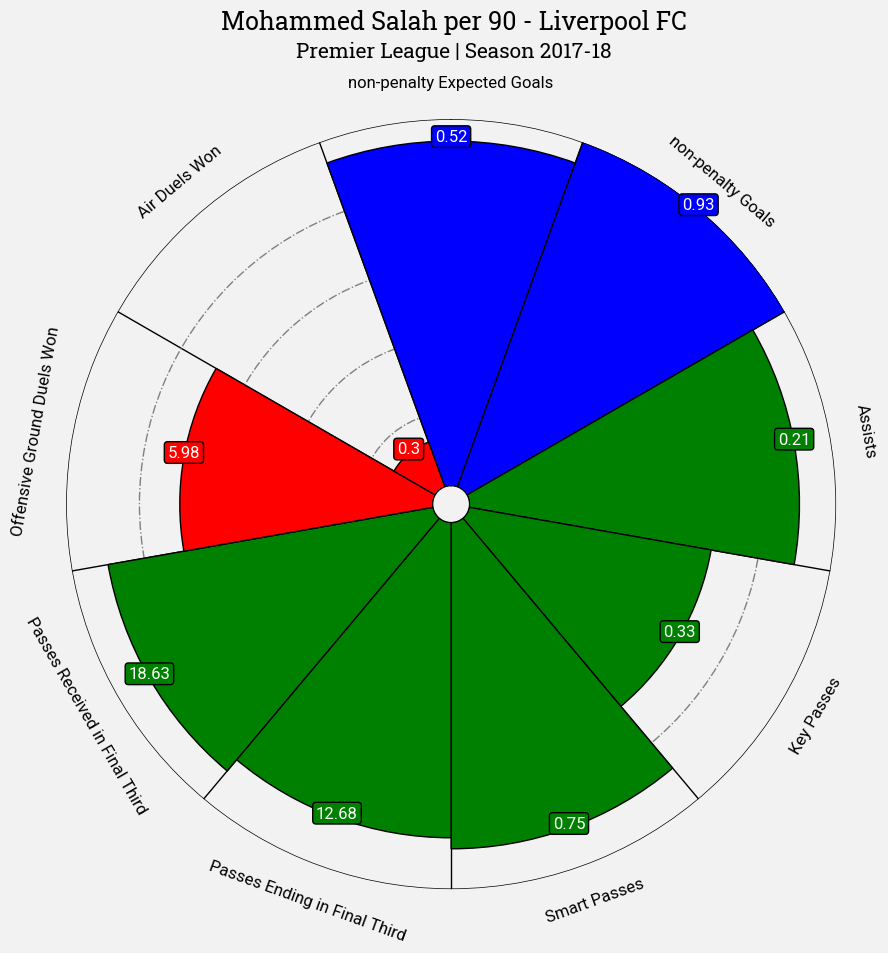

In [16]:
#list of names on plots
names = ["non-penalty Expected Goals", "non-penalty Goals", "Assists", "Key Passes", "Smart Passes", "Passes Ending in Final Third", "Passes Received in Final Third", "Offensive Ground Duels Won", "Air Duels Won"]
slice_colors = ["blue"] * 2 + ["green"] * 5 + ["red"] * 2
text_colors = ["white"] * 9
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=names,   
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Mohammed Salah per 90 - Liverpool FC", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Premier League | Season 2017-18",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

## Calculating possession
As the next step we would like to adjust our plot by the player's team ball possesion while they 
were on the pitch. To do it, for each row of our dataframe with minutes per player per each game 
we take all the events that were made in this game while the player was on the pitch.

We will also use duels, but
don't include lost air duels and lost ground defending duels. Why? Possesion is calculated as number of touches by team divided
by the number all touches. If a player lost ground defending duel, that means that he could have been dribbled by, so he did not
touch the ball. If they lost the air duel, they lost a header. Therefore, we claim that those were mostly events where player may have not
touched the ball (or if he did the team did not take control over it). We sum 
both team passes and these duels and all passes and these duels in this period. We store these values in a 
dictionary. Then, summing them for each player separately and calculating their ratio, we get 
the possesion of the ball by player's team while he was on the pitch. As the last step we merge it with our summary dataframe.

In [17]:
possesion_dict = {}
#for every row in the dataframe
for i, row in minutes_per_game.iterrows():
    #take player id, team id and match id, minute in and minute out
    player_id, team_id, match_id = row["playerId"], row["teamId"], row["matchId"]
    #create a key in dictionary if player encounterd first time
    if not str(player_id) in possesion_dict.keys():
        possesion_dict[str(player_id)] = {'team_passes': 0, 'all_passes' : 0}
    min_in = row["player_in_min"]*60
    min_out = row["player_out_min"]*60
    
    #get the dataframe of events from the game
    match_df = train.loc[train["matchId"] == match_id].copy()
    #add to 2H the highest value of 1H
    match_df.loc[match_df["matchPeriod"] == "2H", 'eventSec'] = match_df.loc[match_df["matchPeriod"] == "2H", 'eventSec'] + match_df.loc[match_df["matchPeriod"] == "1H"]["eventSec"].iloc[-1]
    #take all events from this game and this period
    player_in_match_df = match_df.loc[match_df["eventSec"] > min_in].loc[match_df["eventSec"] <= min_out]
    #take all passes and won duels as described
    all_passes = player_in_match_df.loc[player_in_match_df["eventName"].isin(["Pass", "Duel"])]
    #adjusting for no passes in this period (Tuanzebe)
    if len(all_passes) > 0:
        #removing lost air duels
        no_contact = all_passes.loc[all_passes["subEventName"].isin(["Air duel", "Ground defending duel","Ground loose ball duel"])].loc[all_passes.apply(lambda x:{'id':701} in x.tags, axis = 1)]
        all_passes = all_passes.drop(no_contact.index)
    #take team passes 
    team_passes = all_passes.loc[all_passes["teamId"] == team_id]
    #append it {player id: {team passes: sum, all passes : sum}}
    possesion_dict[str(player_id)]["team_passes"] += len(team_passes)
    possesion_dict[str(player_id)]["all_passes"] += len(all_passes)

#calculate possesion for each player
percentage_dict = {key: value["team_passes"]/value["all_passes"] if value["all_passes"] > 0 else 0 for key, value in possesion_dict.items()}
#create a dataframe
percentage_df = pd.DataFrame(percentage_dict.items(), columns = ["playerId", "possesion"])
percentage_df["playerId"] = percentage_df["playerId"].astype(int)
percentage_df.to_json(os.path.join('..', 'data', 'Wyscout', 'player_possession', 'player_possession_England.json'))
percentage_df.head()

,playerId,possesion
0,9206,0.446999
1,9127,0.439018
2,93,0.438288
3,9179,0.471322
4,10108,0.433335


In [18]:
#merge it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])
summary.head()

,playerId,minutesPlayed,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes,shortName,possesion
0,471,756,1.774309,39.0,69.0,37.0,48.0,4.0,2.0,0.0,1.0,W. Bony,0.461731
1,3324,2143,10.403442,199.0,340.0,170.0,48.0,9.0,11.0,4.0,6.0,Álvaro Morata,0.560137
2,3326,618,0.900291,43.0,81.0,33.0,0.0,3.0,1.0,1.0,3.0,Jesé Rodríguez,0.406015
3,3327,1775,6.118932,133.0,175.0,50.0,134.0,3.0,4.0,1.0,4.0,Joselu,0.419726
4,3348,441,0.711633,49.0,69.0,31.0,0.0,4.0,1.0,0.0,1.0,Deulofeu,0.483754


## Adjusting data for possession
Since we would like to adjust our values by possession, we divide the total statistics by the
possesion while player was on the pitch during the entire season. To normalize the values per 
90 minutes player we repeat the multiplication by 90 and division by minutes played.



In [19]:
#create a new dataframe only for it
summary_adjusted = pd.DataFrame()
summary_adjusted["shortName"] = summary["shortName"]
#calculate value adjusted
for column in summary.columns[2:11]:
    summary_adjusted[column + "_adjusted_per90"] = summary.apply(lambda x: (x[column]/x["possesion"])*90/x["minutesPlayed"], axis = 1)

summary_adjusted.head()

,shortName,npxG_adjusted_per90,final_third_passes_adjusted_per90,final_third_receptions_adjusted_per90,ground_duels_won_adjusted_per90,air_duels_won_adjusted_per90,smart_passes_adjusted_per90,goals_adjusted_per90,assists_adjusted_per90,key_passes_adjusted_per90
0,W. Bony,0.457468,10.055333,17.790205,9.539675,12.375795,1.031316,0.515658,0.000000,0.257829
1,Álvaro Morata,0.780015,14.920356,25.492065,12.746032,3.598880,0.674790,0.824743,0.299907,0.449860
2,Jesé Rodríguez,0.322920,15.423409,29.053398,11.836570,0.000000,1.076052,0.358684,0.358684,1.076052
3,Joselu,0.739186,16.066810,21.140539,6.040154,16.187613,0.362409,0.483212,0.120803,0.483212
4,Deulofeu,0.300217,20.671673,29.109090,13.077997,0.000000,1.687484,0.421871,0.000000,0.421871


## Making the plot with adjusted data for Mohammed Salah
After calculating the values, we repeat the steps by calculating percentiles and plotting radars from 
making the plot per 90. Note that this time we show the percentile rank on the plot.



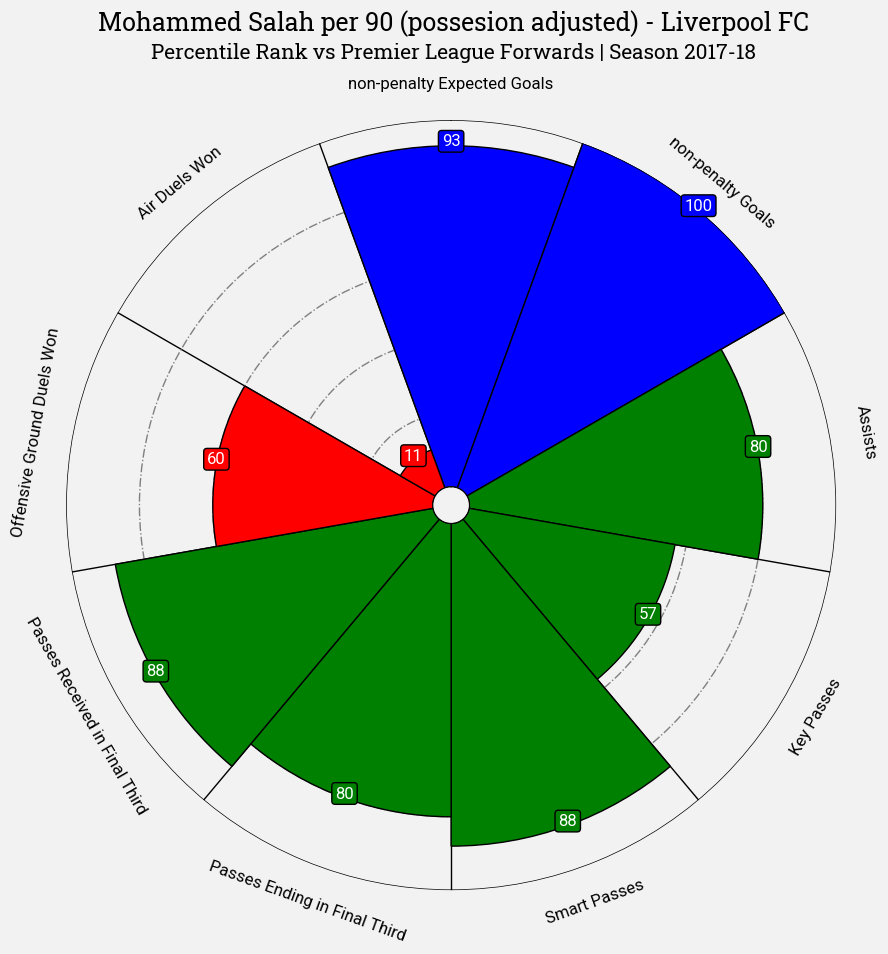

In [20]:
salah_adjusted = summary_adjusted.loc[summary_adjusted["shortName"] == "Mohamed Salah"]
salah_adjusted = salah_adjusted[['npxG_adjusted_per90', "goals_adjusted_per90", "assists_adjusted_per90", "key_passes_adjusted_per90", "smart_passes_adjusted_per90", "final_third_passes_adjusted_per90", "final_third_receptions_adjusted_per90", "ground_duels_won_adjusted_per90", "air_duels_won_adjusted_per90"]]
#take only necessary columns
adjusted_columns = salah_adjusted.columns[:]
#values
values = [salah_adjusted[column].iloc[0] for column in adjusted_columns]
#percentiles
percentiles = [int(stats.percentileofscore(summary_adjusted[column], salah_adjusted[column].iloc[0])) for column in adjusted_columns]
names = names = ["non-penalty Expected Goals", "non-penalty Goals", "Assists", "Key Passes", "Smart Passes", "Passes Ending in Final Third", "Passes Received in Final Third", "Offensive Ground Duels Won", "Air Duels Won"]


font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto-Italic%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))

baker = PyPizza(
    params=names,                  # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors,
    # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

# add title
fig.text(
    0.515, 0.97, "Mohammed Salah per 90 (possesion adjusted) - Liverpool FC", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Percentile Rank vs Premier League Forwards | Season 2017-18",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

plt.show()